In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='grLXj6djiLXUvWtxlD3GHaPF7NDOLezPSXtKTRX77h2O',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'nsapeligibilityprediction-donotdelete-pr-p6zhumd3zkbdv2'
object_key = 'Social Welfare Schemes.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head(10)

,finyear,lgdstatecode,statename,lgddistrictcode,districtname,schemecode,totalbeneficiaries,totalmale,totalfemale,totaltransgender,totalsc,totalst,totalgen,totalobc,totalaadhaar,totalmobilenumber
0,2025-2026,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNDPS,108,72,36,0,0,3,104,1,108,69
1,2025-2026,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNOAPS,8438,5059,3379,0,37,235,8083,83,8371,7190
2,2025-2026,1,JAMMU AND KASHMIR,1,ANANTNAG,IGNWPS,202,0,202,0,1,15,180,6,200,159
3,2025-2026,1,JAMMU AND KASHMIR,10,POONCH,IGNDPS,310,211,99,0,0,77,200,33,234,110
4,2025-2026,1,JAMMU AND KASHMIR,10,POONCH,IGNOAPS,5958,3958,2000,0,2,1347,4367,242,3875,2287
5,2025-2026,1,JAMMU AND KASHMIR,10,POONCH,IGNWPS,382,0,382,0,0,65,298,19,260,90
6,2025-2026,1,JAMMU AND KASHMIR,11,PULWAMA,IGNDPS,95,63,32,0,0,6,81,8,94,93
7,2025-2026,1,JAMMU AND KASHMIR,11,PULWAMA,IGNOAPS,5021,2911,2110,0,1,197,4443,380,5021,4935
8,2025-2026,1,JAMMU AND KASHMIR,11,PULWAMA,IGNWPS,304,0,304,0,0,20,260,24,304,258
9,2025-2026,1,JAMMU AND KASHMIR,12,RAJAURI,IGNDPS,78,52,26,0,5,5,68,0,72,3


In [3]:
# Drop irrelevant columns
df_processed = df.drop(columns=['finyear', 'lgdstatecode', 'lgddistrictcode'])
target = 'schemecode'

In [4]:
#Encode Categorical Features
le_state = LabelEncoder()
df_processed['statename_encoded'] = le_state.fit_transform(df_processed['statename'])

le_district = LabelEncoder()
df_processed['districtname_encoded'] = le_district.fit_transform(df_processed['districtname'])

In [5]:
#Create Ratio Features
df_processed['male_ratio'] = df_processed['totalmale'] / df_processed['totalbeneficiaries']
df_processed['female_ratio'] = df_processed['totalfemale'] / df_processed['totalbeneficiaries']
df_processed['sc_ratio'] = df_processed['totalsc'] / df_processed['totalbeneficiaries']
df_processed['st_ratio'] = df_processed['totalst'] / df_processed['totalbeneficiaries']
df_processed['gen_ratio'] = df_processed['totalgen'] / df_processed['totalbeneficiaries']
df_processed['obc_ratio'] = df_processed['totalobc'] / df_processed['totalbeneficiaries']

df_processed.fillna(0, inplace=True)

In [6]:
#Define Features and Target
X = df_processed[['statename_encoded', 'districtname_encoded', 'totalbeneficiaries', 
                  'totalmale', 'totalfemale', 'totaltransgender', 
                  'totalsc', 'totalst', 'totalgen', 'totalobc', 
                  'male_ratio', 'female_ratio', 'sc_ratio', 'st_ratio', 
                  'gen_ratio', 'obc_ratio']]
y = df_processed[target]

In [7]:
#Train-Test Split and Feature Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
#Initialize Ensemble Model
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='hard')

In [9]:
# Train Ensemble Model
ensemble_model.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))])

In [10]:
#Model Evaluation
y_pred = ensemble_model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9815
Classification Report:
              precision    recall  f1-score   support

      IGNDPS       0.96      0.98      0.97       139
     IGNOAPS       0.98      0.97      0.97       151
      IGNWPS       1.00      1.00      1.00       142

    accuracy                           0.98       432
   macro avg       0.98      0.98      0.98       432
weighted avg       0.98      0.98      0.98       432



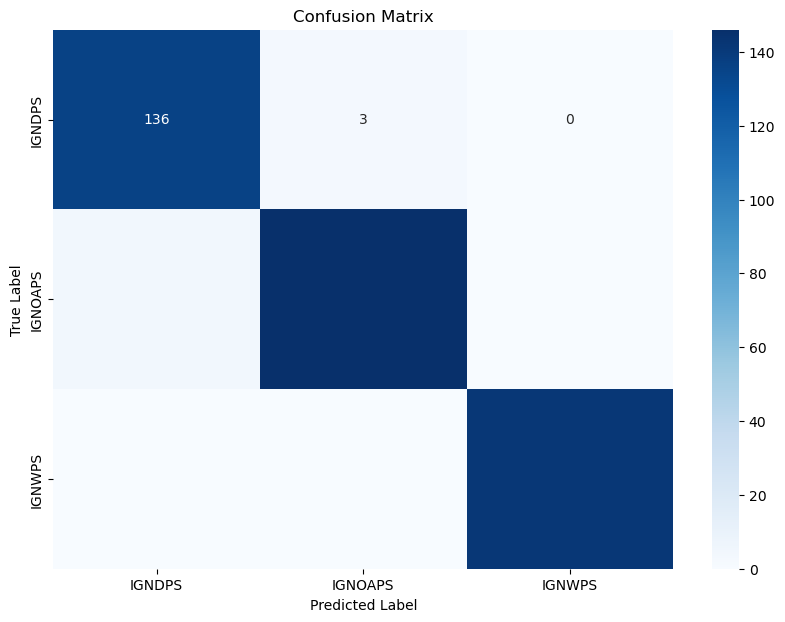

In [11]:
#Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
scheme_labels = np.unique(y)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=scheme_labels, yticklabels=scheme_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
#New Applicant Data Input
new_applicant_data = {
    'statename': 'JAMMU AND KASHMIR',
    'districtname': 'ANANTNAG',
    'totalbeneficiaries': 8438,
    'totalmale': 5059,
    'totalfemale': 3379,
    'totaltransgender': 0,
    'totalsc': 37,
    'totalst': 235,
    'totalgen': 8083,
    'totalobc': 83
}
new_applicant_df = pd.DataFrame([new_applicant_data])

new_applicant_df['statename_encoded'] = le_state.transform(new_applicant_df['statename'])
new_applicant_df['districtname_encoded'] = le_district.transform(new_applicant_df['districtname'])

new_applicant_df['male_ratio'] = new_applicant_df['totalmale'] / new_applicant_df['totalbeneficiaries']
new_applicant_df['female_ratio'] = new_applicant_df['totalfemale'] / new_applicant_df['totalbeneficiaries']
new_applicant_df['sc_ratio'] = new_applicant_df['totalsc'] / new_applicant_df['totalbeneficiaries']
new_applicant_df['st_ratio'] = new_applicant_df['totalst'] / new_applicant_df['totalbeneficiaries']
new_applicant_df['gen_ratio'] = new_applicant_df['totalgen'] / new_applicant_df['totalbeneficiaries']
new_applicant_df['obc_ratio'] = new_applicant_df['totalobc'] / new_applicant_df['totalbeneficiaries']

new_applicant_df.fillna(0, inplace=True)

# Select and scale input
new_applicant_features = new_applicant_df[['statename_encoded', 'districtname_encoded', 
                                             'totalbeneficiaries', 'totalmale', 
                                             'totalfemale', 'totaltransgender', 
                                             'totalsc', 'totalst', 'totalgen', 
                                             'totalobc', 'male_ratio', 'female_ratio', 
                                             'sc_ratio', 'st_ratio', 'gen_ratio', 
                                             'obc_ratio']]

new_applicant_scaled = scaler.transform(new_applicant_features)

# Predict
predicted_scheme = ensemble_model.predict(new_applicant_scaled)
print(f"Predicted NSAP Scheme: {predicted_scheme[0]}")

Predicted NSAP Scheme: IGNOAPS


In [13]:
import joblib

# Save the model to a .pkl file
joblib.dump(ensemble_model, 'ensemble_model.pkl')

print("Model saved to ensemble_model.pkl")

Model saved to ensemble_model.pkl
